## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import time
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sb

## Loading Dataset

In [3]:
gta = pd.read_csv('gta_translated_text.csv', header=[0]) #google reviews
amazon =  pd.read_csv('amazon_translated_text_new.csv', header=[0]) # amaon reviews

In [4]:
print(gta.head())
print(amazon.head())

                                            comments  rating  helpful label
0  even 8 years later, this game is easily one of...       5      262  Good
1  even 8 years later, this game is easily one of...       5      217  Good
2  grand theft auto v is a 2013 action-adventure ...       5       51  Good
3  grand theft auto v is a 2013 action-adventure ...       5      653  Good
4  warning: spoilerstrevor is just love!! he has ...       5        5  Good
                                            comments  rating  helpful   label
0            So fun and the characters are hilarious       5        0    Good
1                 Arrived quickly in great condition       5        0    Good
2  Ha ha Stress relief by blowing stuff up in thi...       5        0    Good
3  Super product Delivery Before time consistent ...       5        0    Good
4  I don't understand why this game is still play...       3        1  Normal


### Merging two datasets(Amazon and Google)

In [5]:
gta_df = pd.concat([gta, amazon], ignore_index=True, axis=0)
print(gta_df.head())
print(gta_df.shape)

                                            comments  rating  helpful label
0  even 8 years later, this game is easily one of...       5      262  Good
1  even 8 years later, this game is easily one of...       5      217  Good
2  grand theft auto v is a 2013 action-adventure ...       5       51  Good
3  grand theft auto v is a 2013 action-adventure ...       5      653  Good
4  warning: spoilerstrevor is just love!! he has ...       5        5  Good
(4986, 4)


In [6]:
gta_df.describe()

,rating,helpful
count,4986.000000,4986.000000
mean,4.320096,1.421580
std,1.415711,20.782167
min,0.000000,0.000000
25%,5.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,0.000000
max,5.000000,1025.000000


## Visualize Ratings

In [7]:
%matplotlib inline
rcParams['figure.figsize'] = 5,5
sb.set_style('whitegrid')

<Axes: ylabel='Frequency'>

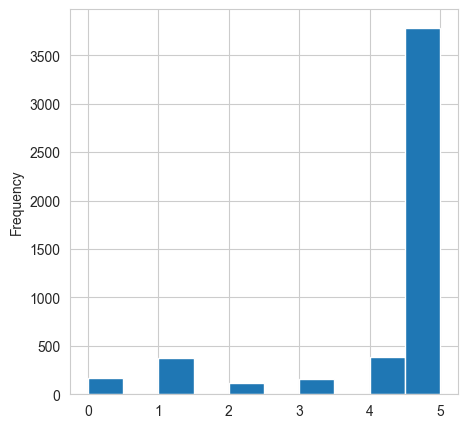

In [8]:
gta_df.rating.plot(kind='hist')

In [9]:
gta_df.to_csv('merged_data.csv', index=False)

## Text Wrangling and Cleaning

### Importing Libraries

In [10]:
import nltk

from autocorrect import Speller #auto correct spellings
spell = Speller(lang='en')

wn = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import json

with open('ShortendText.json','r') as file: #loading shortened text/SLANGS dictionary scraped through slang_words.ipynb
    Abbr_dict=json.loads(file.read())
    
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

#replacing some of shortened word dictionary
Abbr_dict['im'] = 'i am'  #it was instant messaging
Abbr_dict['don'] = "dont" #it was denial of normal

### Using different function to seperate sentences. Didn't used sent_tokenize as it expects space after period and it wasn't spliting it that correctly.

In [11]:
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|edu|me)"
digits = "([0-9])"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    if "..." in text: text = text.replace("...","<prd><prd><prd>")
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    #print("split","<stop>" not in text)
    if "<stop>" in text:
        sentences = sentences[:-1]
    #print("split",sentences)
    sentences = [s.strip() for s in sentences]
    #print("strip",sentences)
    return sentences

### Function to clean text

In [12]:
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()
def clean_text(text_original): 
    text=""
    sentences = split_into_sentences(text_original) #split the text into sentences
    #print(sentences)
    for sent in sentences: #remove puncuations 
        text += " "
        for i in sent:
            if i !="’": #"’" this character is not in sting.punctuation
                i = re.sub(r"'",'',i)
                text += "".join([word.lower() for word in i if word not in string.punctuation])            
 
    text = re.sub(r"[0-9]+", "",text); #removing numbers
    
    #tokens = [x.replace("’", '') for x in tweet_tokenizer.tokenize(text)]
    tokens = word_tokenize(text) #Tokenize into words
    #print("Tokens:\n",tokens)
    
    for i,token in enumerate(tokens): # Using auto correct to correct some spellings
        tokens[i] = spell(token)
    #print("Auto correct:\n",tokens)

    for i,token in enumerate(tokens): #convert the slang words using dictionary scraped through slang_words.ipynb
        for j in Abbr_dict:
            if j==token:
                #print("Abbreviation ", j, ":", Abbr_dict[j])
                del tokens[i] 
                abbr=""
                for i in Abbr_dict[j]:
                    abbr += "".join([word.lower() for word in i if word not in string.punctuation])
                #print(abbr)
                #abbr_tokens = [x.replace("’", '') for x in tweet_tokenizer.tokenize(abbr)]
                abbr_tokens = word_tokenize(abbr) #Abbr may have some stop words hence tokenizing it againabbr
                tokens.extend(abbr_tokens)
    
    #print(tokens) 
    
    text = [wn.lemmatize(word, pos='n') for word in tokens if word not in stopwords] #lemmatizing
    #print(text)
    return text

## Clean the text and store it in column

In [14]:
gta_df['comments_cleaned'] = gta_df['comments'].apply(lambda x: clean_text(x))

## Create a column to store length of the reviews

In [15]:
gta_df['comments_len'] = gta_df['comments'].apply(lambda x: len(x) - x.count(" "))

In [16]:
gta_df.head()

,comments,rating,helpful,label,comments_cleaned,comments_len
0,"even 8 years later, this game is easily one of...",5,262,Good,"[even, year, later, game, easily, one, best, b...",1019
1,"even 8 years later, this game is easily one of...",5,217,Good,"[even, year, later, game, easily, one, best, b...",1019
2,grand theft auto v is a 2013 action-adventure ...,5,51,Good,"[grand, theft, auto, v, actionadventure, game,...",2600
3,grand theft auto v is a 2013 action-adventure ...,5,653,Good,"[grand, theft, auto, v, actionadventure, game,...",2600
4,warning: spoilerstrevor is just love!! he has ...,5,5,Good,"[warning, spoilerstrevor, love, tough, guy, lo...",1660


In [17]:
from matplotlib import pyplot
import numpy as np
%matplotlib inline

In [18]:
# Fill na as bad because the reviews not rated means 0 star
gta_df['label'] = gta_df['label'].fillna('Bad')

## Body length distribution

### Body Length Distribution of whole dataset

(4986, 6)


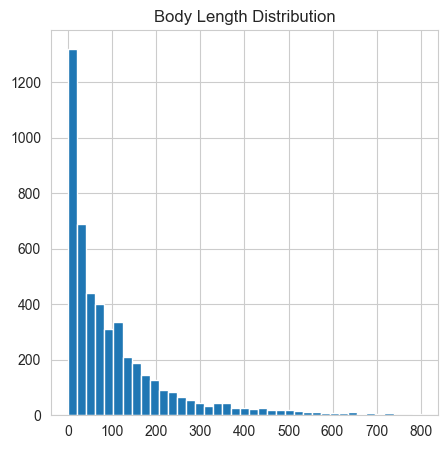

In [146]:
bins = np.linspace(0,800, 40)
print(gta_df.shape)
pyplot.hist(gta_df['comments_len'], bins)
pyplot.title("Body Length Distribution")
pyplot.show()

### Body Length Distribution of Good reviews

(4173, 6)


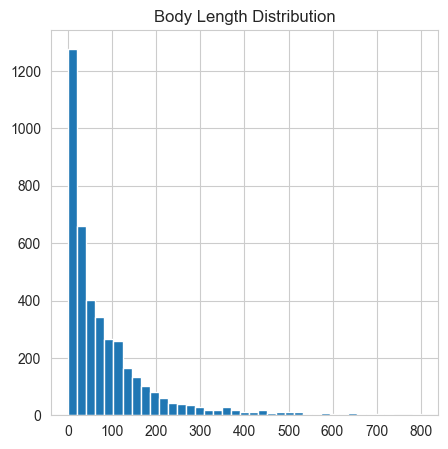

In [20]:
good_df = gta_df[gta_df['label']=='Good']
print(good_df.shape)
pyplot.hist(good_df['comments_len'], bins)
pyplot.title("Body Length Distribution")
pyplot.show()

#This is almost same as whole dataset distribution

### Body Length Distribution of Normal reviews

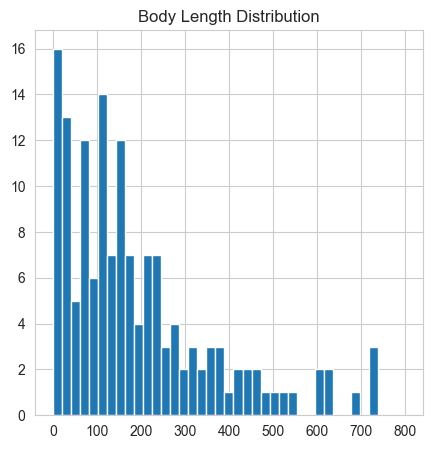

In [147]:
normal_df = gta_df[gta_df['label']=='Normal']
#print(normal_df.shape)
pyplot.hist(normal_df['comments_len'], bins)
pyplot.title("Body Length Distribution")
pyplot.show()

#Most of them lie between 1-300 words.

### Body Length Distribution of Bad reviews

(660, 6)


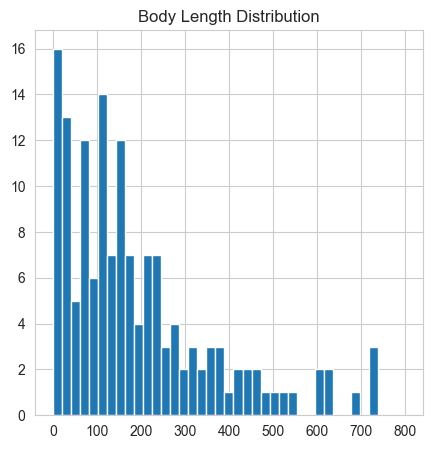

In [22]:
bad_df = gta_df[gta_df['label']=='Bad']
print(bad_df.shape)
pyplot.hist(normal_df['comments_len'], bins)
pyplot.title("Body Length Distribution")
pyplot.show()

## Most common words

In [23]:
word_corpus = []
for i in gta_df['comments_cleaned']:
    word_corpus.extend(i)
#Frequenc distribution: frequency of words
counter_dict = nltk.FreqDist(word_corpus)
print(counter_dict.most_common(15))

[('game', 5169), ('auto', 1472), ('grand', 1466), ('theft', 1463), ('good', 1009), ('great', 922), ('play', 891), ('online', 836), ('like', 813), ('best', 723), ('love', 703), ('time', 659), ('p', 607), ('one', 597), ('get', 572)]


(array([   0., 1000., 2000., 3000., 4000., 5000., 6000.]),
 [Text(0.0, 0, '0'),
  Text(1000.0, 0, '1000'),
  Text(2000.0, 0, '2000'),
  Text(3000.0, 0, '3000'),
  Text(4000.0, 0, '4000'),
  Text(5000.0, 0, '5000'),
  Text(6000.0, 0, '6000')])

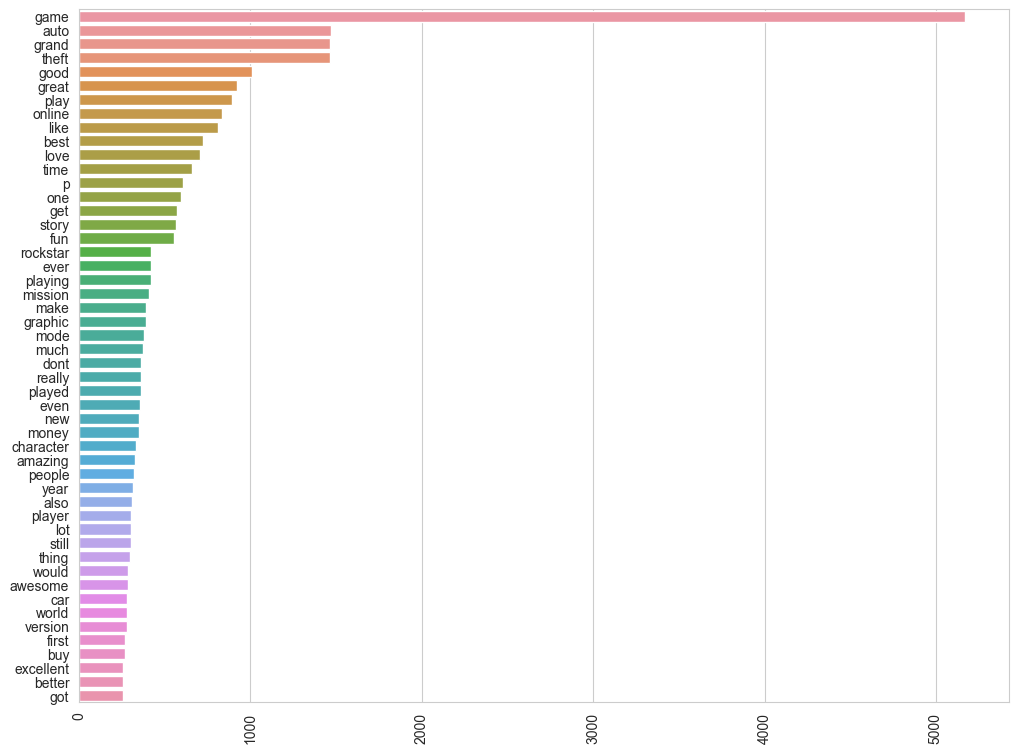

In [24]:
import seaborn as sns

plt.figure(figsize=(12,9))
m, n= [], []

for word,count in counter_dict.most_common(50):
    m.append(count)
    n.append(word)
sns.barplot(x=m,y=n)
plt.xticks(rotation=90)

# Word Cloud

### Word cloud of whole dataset

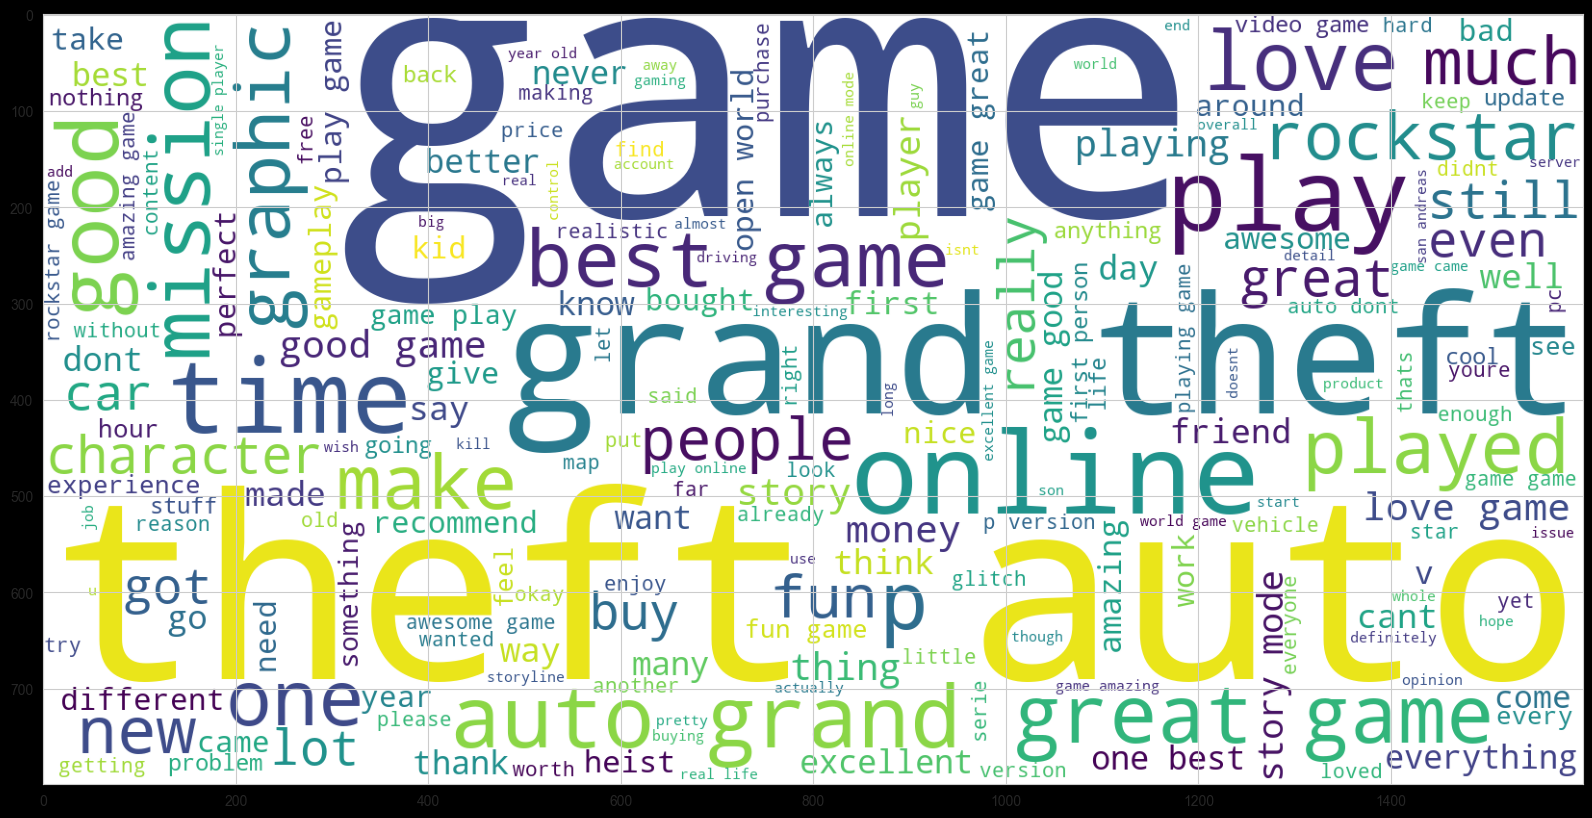

In [25]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(np.array(word_corpus).tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

### Word cloud of low rating reviews

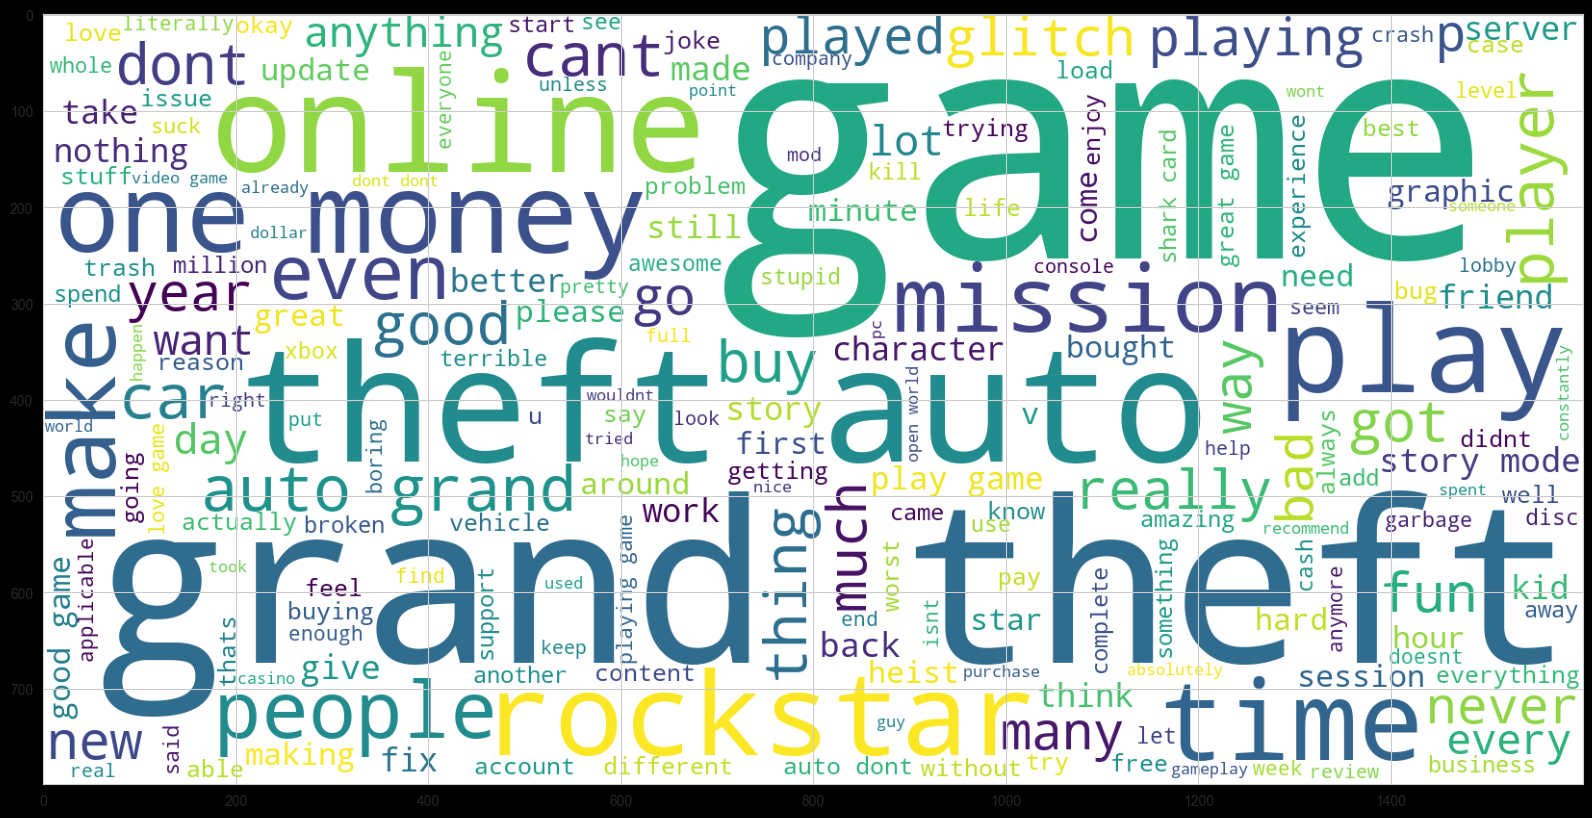

In [26]:
bad_df = gta_df[gta_df['label']=='Bad']
bad_word_corpus = []
for i in bad_df['comments_cleaned']:
    bad_word_corpus.extend(i)
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(np.array(bad_word_corpus).tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0.0, 0, '0'),
  Text(200.0, 0, '200'),
  Text(400.0, 0, '400'),
  Text(600.0, 0, '600'),
  Text(800.0, 0, '800'),
  Text(1000.0, 0, '1000'),
  Text(1200.0, 0, '1200')])

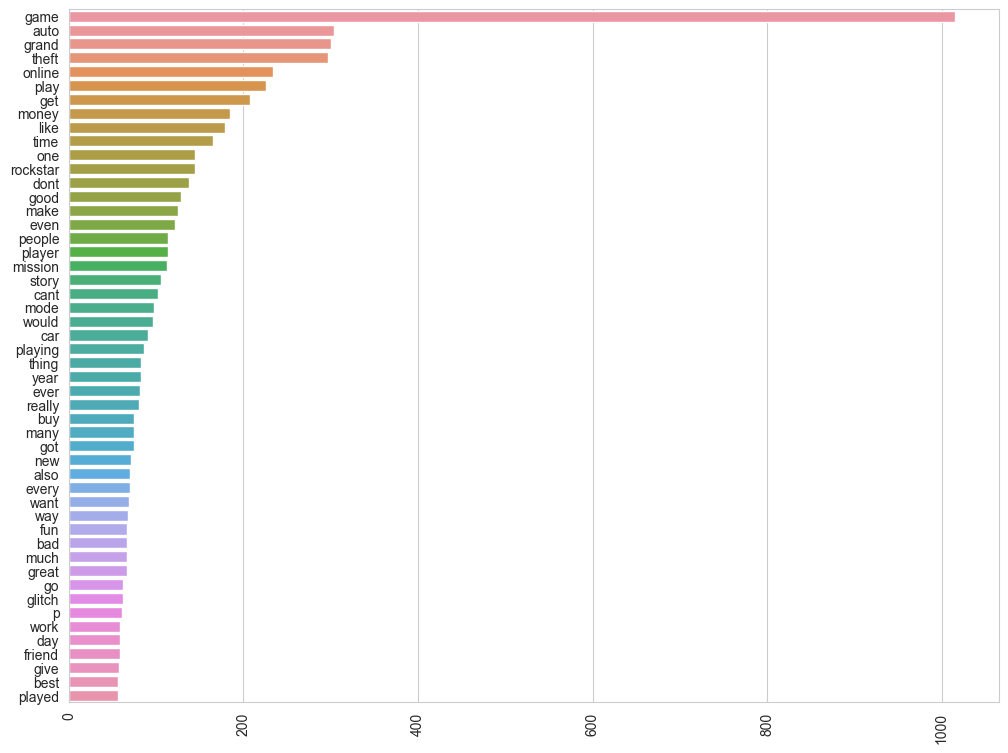

In [27]:
counter_dict = nltk.FreqDist(bad_word_corpus)

import seaborn as sns
plt.figure(figsize=(12,9))

m, n= [], []

for word,count in counter_dict.most_common(50):
    m.append(count)
    n.append(word)
sns.barplot(x=m,y=n)
plt.xticks(rotation=90)

#some noticable reviews words are dont cant bad glitch

## Word Cloud of normal ratings

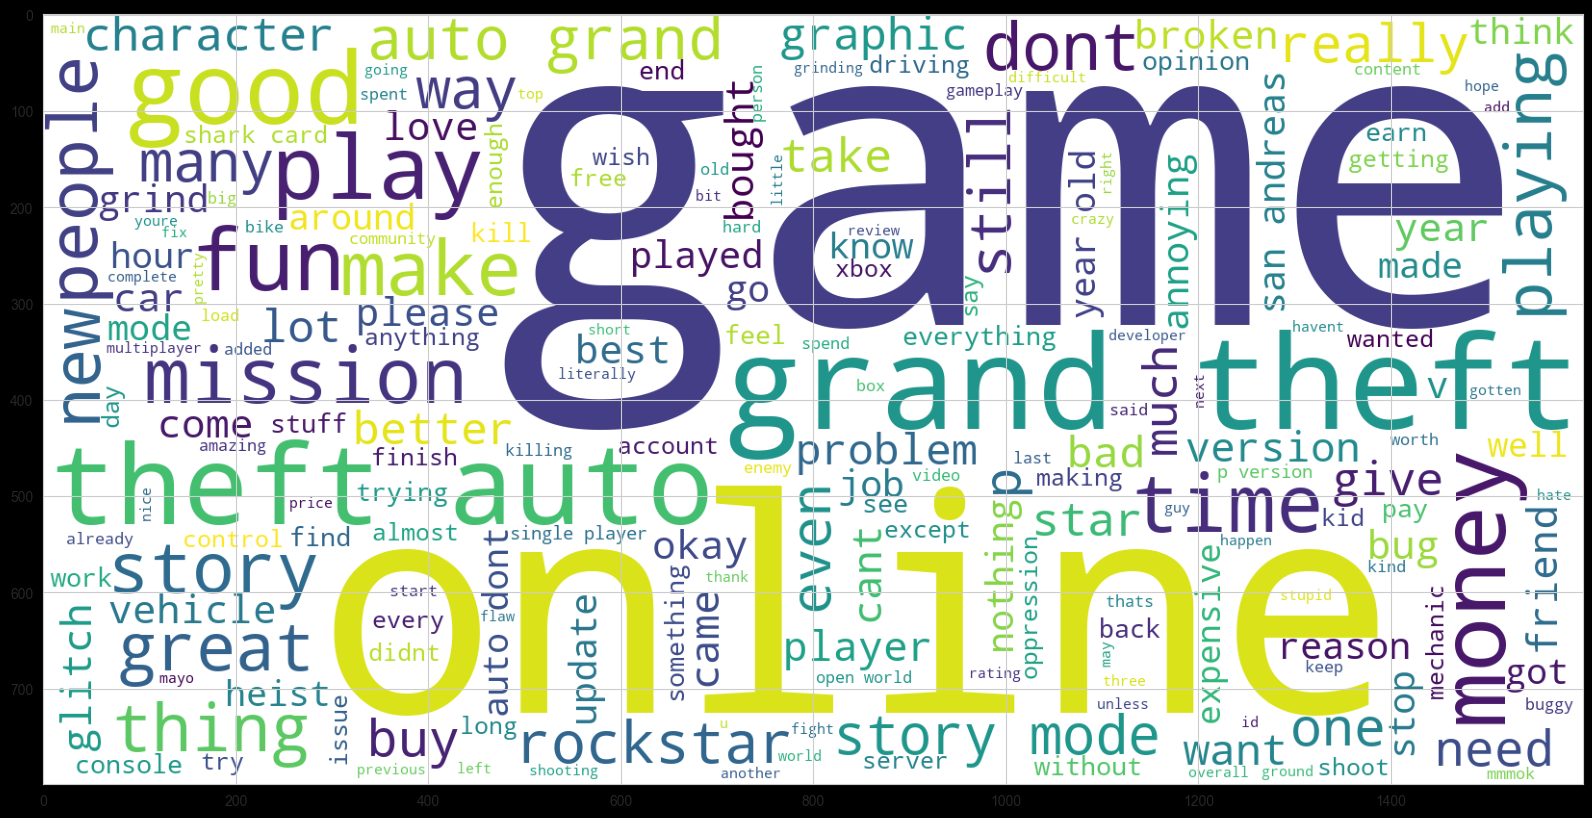

In [28]:
normal_df = gta_df[gta_df['label']=='Normal']
normal_word_corpus = []
for i in normal_df['comments_cleaned']:
    normal_word_corpus.extend(i)
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(np.array(normal_word_corpus).tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

(array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 [Text(0.0, 0, '0'),
  Text(25.0, 0, '25'),
  Text(50.0, 0, '50'),
  Text(75.0, 0, '75'),
  Text(100.0, 0, '100'),
  Text(125.0, 0, '125'),
  Text(150.0, 0, '150'),
  Text(175.0, 0, '175'),
  Text(200.0, 0, '200')])

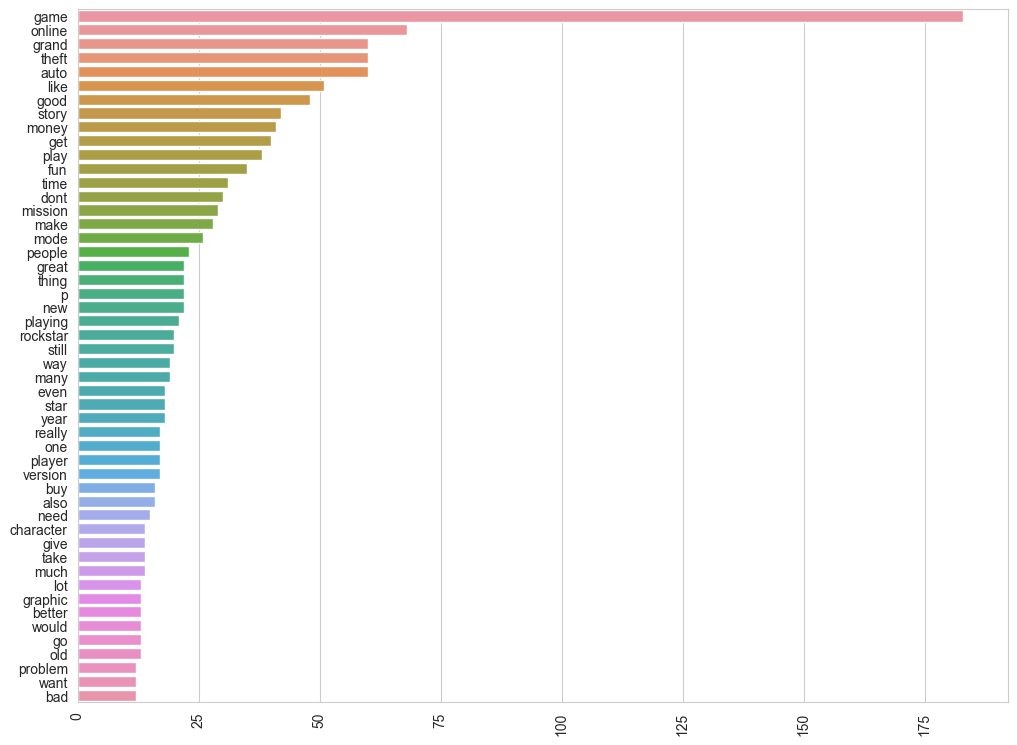

In [29]:
counter_dict = nltk.FreqDist(normal_word_corpus)

import seaborn as sns
plt.figure(figsize=(12,9))

m, n= [], []

for word,count in counter_dict.most_common(50):
    m.append(count)
    n.append(word)
sns.barplot(x=m,y=n)
plt.xticks(rotation=90)

## Seperating Features and Target

In [30]:
X = gta_df.iloc[:,[0,2,4,5]]
y = gta_df.loc[:,'label']

## Label encoding for target

In [31]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

## Seperating dataset into train and test

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

## TF-IDF

In [33]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['comments'])

tfidf_train = tfidf_vect_fit.transform(X_train['comments'])
tfidf_test = tfidf_vect_fit.transform(X_test['comments'])
X_train_vect = pd.concat([X_train[['comments_len']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['comments_len']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,comments_len,0,1,2,3,4,5,6,7,8,...,5743,5744,5745,5746,5747,5748,5749,5750,5751,5752
0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
X_train_vect.shape

(3739, 5754)

## Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import time

In [36]:
#Initlializing model
from sklearn.svm import SVR # non-linear
regressor = RandomForestClassifier() 


from sklearn.model_selection import GridSearchCV

#Initializing different parameters that will be used in grid search 
parameters = [{'n_estimators':[100,150,200,250,300]}]

grid_search = GridSearchCV(estimator=regressor, 
                           param_grid=parameters,
                           scoring='accuracy',  #scoring method will be R square
                           cv=10,         #ten sets for CROSS VALIDATION
                           n_jobs=-1)     #n_jobs=-1 will use all the available processors

#Fitting it on train set
grid_search.fit(X_train_vect, y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:",best_parameters)

2023-03-24 10:21:10,401 [28380] WARNING  py.warnings:109: [JupyterRequire] C:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(



Best Accuracy: 85.80 %
Best Parameters: {'n_estimators': 300}


In [152]:
rf = RandomForestClassifier(n_estimators=200, max_depth=None, n_jobs=-1)
rf_model = rf.fit(X_train_vect, y_train)
y_pred = rf_model.predict(X_test_vect)

2023-03-25 19:23:23,608 [28380] WARNING  py.warnings:109: [JupyterRequire] C:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(

2023-03-25 19:23:26,354 [28380] WARNING  py.warnings:109: [JupyterRequire] C:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(



In [154]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
print(cm)
accuracy_score(y_test, y_pred)
le.inverse_transform([2])

[[  26  137    0]
 [   1 1046    0]
 [   3   34    0]]


array(['Normal'], dtype=object)

### Training with only 2000 features

In [73]:
# Below code sums the column wise tfidf value and sorts it 
importance = np.argsort (np.asarray (tfidf_train.sum (axis=0)).ravel ()) [::-1]
tfidf_feature_names = np.array (tfidf_vect.get_feature_names_out())

tfidf_feature_names[importance [:4000]]

array(['game', 'good', 'great', ..., 'plead', 'unfriendly', 'stabbed'],
      dtype=object)

In [40]:
#Initlializing model
from sklearn.svm import SVR # non-linear
regressor = RandomForestClassifier() 


from sklearn.model_selection import GridSearchCV

#Initializing different parameters that will be used in grid search 
parameters = [{'n_estimators':[100,150,200,250,300]}]

grid_search = GridSearchCV(estimator=regressor, 
                           param_grid=parameters,
                           scoring='accuracy',  #scoring method will be R square
                           cv=10,         #ten sets for CROSS VALIDATION
                           n_jobs=-1)     #n_jobs=-1 will use all the available processors

#Fitting it on train set
grid_search.fit(tfidf_train[:,importance[:2000]], y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:",best_parameters)

Best Accuracy: 86.44 %
Best Parameters: {'n_estimators': 200}


In [41]:
rf = RandomForestClassifier(n_estimators=250, max_depth=None, n_jobs=-1)
rf_model = rf.fit(tfidf_train[:,importance[:2000]], y_train)
y_pred = rf_model.predict(tfidf_test[:,importance[:2000]])
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[  42  121    0]
 [   5 1042    0]
 [   5   32    0]]


0.8692862870890137

## Naive Baiyes

In [42]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train_vect, y_train)

2023-03-24 10:21:59,647 [28380] WARNING  py.warnings:109: [JupyterRequire] C:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(



GaussianNB()

In [43]:
y_pred = classifier.predict(X_test_vect)
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

2023-03-24 10:22:00,240 [28380] WARNING  py.warnings:109: [JupyterRequire] C:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(



[[ 78  43  42]
 [108 592 347]
 [ 11  10  16]]


0.5501202886928629

## Kernal SVM

In [44]:
#Initlializing model
from sklearn.svm import SVC 
classifier = SVC(kernel = 'rbf') 


from sklearn.model_selection import GridSearchCV

#Initializing different parameters that will be used in grid search 
parameters = [{'C':[0.25, 0.5, 0.75, 1], 'kernel':['rbf'], 'gamma':['scale', 'auto'], 'degree':[1]}]

grid_search = GridSearchCV(estimator=classifier, 
                           param_grid=parameters,
                           scoring='accuracy',  #scoring method will be R square
                           cv=10,         #ten sets for cross validation
                           n_jobs=-1)     #n_jobs=-1 will use all the available processors

#Fitting it on train set
grid_search.fit(X_train_vect, y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:",best_parameters)

#Accuracy is low hence did not test it on test data.

2023-03-24 10:33:24,122 [28380] WARNING  py.warnings:109: [JupyterRequire] C:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(



Best Accuracy: 83.63 %
Best Parameters: {'C': 0.75, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}


## Using Most common features to use nltk Naive Bayes

In [45]:
word_corpus = []
for i in X_train['comments_cleaned']:
    word_corpus.extend(i)
#Frequenc distribution: frequency of words
counter_dict = nltk.FreqDist(word_corpus)
print(counter_dict.most_common(15))

[('game', 3865), ('auto', 1117), ('grand', 1115), ('theft', 1110), ('good', 754), ('great', 699), ('play', 682), ('online', 621), ('like', 616), ('best', 548), ('love', 540), ('time', 493), ('one', 440), ('p', 437), ('story', 431)]


In [46]:
word_features = [w[0] for w in counter_dict.most_common(2500)]
word_features[-10:]
#2500 got the best accuracy after that it didn't increase much

['carrier',
 'empire',
 'announced',
 'growing',
 'local',
 'charisma',
 'firefighter',
 'magic',
 'korean',
 'stable']

In [47]:
def search_features(doc):
    words = set(doc)
    features = {}
    for w in word_features:
        features[w] = (w in words)
    return features

In [48]:
X_train['comments_cleaned'].iloc[1]

['want',
 'join',
 'online',
 'say',
 'rockstar',
 'service',
 'unavailable',
 'hack',
 'happening',
 'need',
 'rock',
 'star',
 'game',
 'smooth',
 'coming',
 'day']

In [49]:
train_features=[]
for i,y in enumerate(y_train):
    train_features.append((search_features(X_train['comments_cleaned'].iloc[i]), y))

test_features=[]
for i,y in enumerate(y_test):
    test_features.append((search_features(X_test['comments_cleaned'].iloc[i]), y))

In [50]:
train_features[:1]

[({'game': False,
   'auto': False,
   'grand': False,
   'theft': False,
   'good': True,
   'great': False,
   'play': False,
   'online': False,
   'like': False,
   'best': False,
   'love': False,
   'time': False,
   'one': False,
   'p': False,
   'story': False,
   'get': False,
   'fun': False,
   'rockstar': False,
   'ever': False,
   'playing': False,
   'mission': False,
   'graphic': False,
   'mode': False,
   'much': False,
   'make': False,
   'dont': False,
   'played': False,
   'character': False,
   'even': False,
   'new': False,
   'really': False,
   'money': False,
   'amazing': False,
   'year': False,
   'player': False,
   'still': False,
   'also': False,
   'awesome': False,
   'people': False,
   'world': False,
   'thing': False,
   'car': False,
   'first': False,
   'version': False,
   'buy': False,
   'would': False,
   'lot': False,
   'better': False,
   'excellent': False,
   'cant': False,
   'well': False,
   'many': False,
   'got': False,
   '

### Naive Baiyes

In [51]:
classifer = nltk.NaiveBayesClassifier.train(train_features)

In [52]:
print("Classfier accuracy:{}".format(nltk.classify.accuracy(classifer,test_features)*100))

Classfier accuracy:82.35765838011227


In [53]:
print("Classfier accuracy:{}".format(nltk.classify.accuracy(classifer,train_features)*100))

Classfier accuracy:85.63787108852634


# Bag of Words

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(analyzer=clean_text)
bag_of_words_x_train = count.fit_transform(X_train['comments'])

In [55]:
bag_of_words_x_test = count.transform(X_test['comments'])

X_train_vect_bow = pd.concat([X_train[['comments_len']].reset_index(drop=True), 
           pd.DataFrame(bag_of_words_x_train.toarray())], axis=1)
X_test_vect_bow = pd.concat([X_test[['comments_len']].reset_index(drop=True), 
           pd.DataFrame(bag_of_words_x_test.toarray())], axis=1)

### Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score

In [57]:
#Initlializing model
from sklearn.svm import SVR # non-linear
regressor = RandomForestClassifier() 


from sklearn.model_selection import GridSearchCV

#Initializing different parameters that will be used in grid search 
parameters = [{'n_estimators':[100,150,200,250,300]}]

grid_search = GridSearchCV(estimator=regressor, 
                           param_grid=parameters,
                           scoring='accuracy',  #scoring method will be R square
                           cv=10,         #ten sets for CROSS VALIDATION
                           n_jobs=-1)     #n_jobs=-1 will use all the available processors

#Fitting it on train set
grid_search.fit(X_train_vect_bow, y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:",best_parameters)

2023-03-24 10:44:17,952 [28380] WARNING  py.warnings:109: [JupyterRequire] C:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(



Best Accuracy: 86.12 %
Best Parameters: {'n_estimators': 100}


In [58]:
rf = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1)
rf_model = rf.fit(X_train_vect, y_train)
y_pred = rf_model.predict(X_test_vect)

2023-03-24 10:44:23,296 [28380] WARNING  py.warnings:109: [JupyterRequire] C:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(

2023-03-24 10:44:24,349 [28380] WARNING  py.warnings:109: [JupyterRequire] C:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(



In [59]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[  28  135    0]
 [   5 1042    0]
 [   7   30    0]]


0.8580593424218124

## Bigrams 

In [75]:
from nltk import bigrams
word_corpus = []
for i in X_train['comments_cleaned']:
    word_corpus.extend(i)

print(len(word_corpus))
bigram_measures = BigramAssocMeasures()
bcf = BigramCollocationFinder.from_documents(X_train['comments_cleaned'])
#print(bcf.nbest(BigramAssocMeasures.likelihood_ratio, 10))

bcf.apply_freq_filter(2)  # Only keep bigrams that appear at least twice
bcf.apply_word_filter(lambda w: len(w) < 2)  # Exclude short words
bcf.apply_ngram_filter(lambda w1, w2: w1 == 'the')  # Exclude bigrams containing 'the'
scored_bigrams = bcf.score_ngrams(bigram_measures.pmi)
#print(scored_bigrams)


# Convert bigram collocations to list of strings
docs = []
for doc in X_train['comments_cleaned']:
    
    doc_bigrams = ['_'.join(bigram) for bigram in list(bigrams(doc))]
    
    for i, word in enumerate(doc_bigrams):
        if len(word)>0: 
            t = re.findall(r'_\b',str(word))
            if len(t)>0:
                #print("end",doc_bigrams[i])
                del doc_bigrams[i]

            n = re.findall(r'\A_',str(word))
            if len(n)>0:
                #print("start", word)
                del doc_bigrams[i]
    docs.append(' '.join(doc_bigrams))

# Create TF-IDF vector
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(docs)

# Print TF-IDF vector
print(tfidf_matrix.toarray())

59511
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [61]:
test_doc=[]
for doc in X_test['comments_cleaned']:
    
    doc_bigrams = ['_'.join(bigram) for bigram in list(bigrams(doc))]
    
    for i, word in enumerate(doc_bigrams):
        if len(word)>0: 
            t = re.findall(r'_\b',str(word))
            if len(t)>0:
                #print("end",doc_bigrams[i])
                del doc_bigrams[i]

            n = re.findall(r'\A_',str(word))
            if len(n)>0:
                #print("start", word)
                del doc_bigrams[i]
    test_doc.append(' '.join(doc_bigrams))

In [62]:
tfidf_matrix_test = vectorizer.transform(test_doc)

### Random forest on Bigram

In [63]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score

In [64]:
#Initlializing model
from sklearn.svm import SVR # non-linear
regressor = RandomForestClassifier() 


from sklearn.model_selection import GridSearchCV

#Initializing different parameters that will be used in grid search 
parameters = [{'n_estimators':[100,150,200,250,300]}]

grid_search = GridSearchCV(estimator=regressor, 
                           param_grid=parameters,
                           scoring='accuracy',  #scoring method will be R square
                           cv=10,         #ten sets for CROSS VALIDATION
                           n_jobs=-1)     #n_jobs=-1 will use all the available processors

#Fitting it on train set
grid_search.fit(tfidf_matrix, y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:",best_parameters)

Best Accuracy: 84.03 %
Best Parameters: {'n_estimators': 100}


In [65]:
rf = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1)
rf_model = rf.fit(tfidf_matrix, y_train)
y_pred = rf_model.predict(tfidf_matrix_test)

from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[  11  152    0]
 [   1 1046    0]
 [   2   35    0]]


0.8476343223736968

## Bigram and Unigram matrix for training

### Getting the top 20000 BigramTFIDF

In [66]:
np.asarray (tfidf_matrix.sum (axis=0)).ravel ()

array([0.18289725, 0.07347621, 0.16592606, ..., 0.06960265, 0.06960265,
       0.06960265])

In [76]:
imp = np.argsort (np.asarray (tfidf_matrix.sum (axis=0)).ravel ()) [::-1]
tfidf_feature_names = np.array (vectorizer.get_feature_names_out())

In [77]:
tfidf_feature_names[imp[:20000]]

array(['great_game', 'theft_auto', 'grand_theft', ..., 'solo_turned',
       'farm_cash', 'garbage_problem'], dtype=object)

### Merging uni-gram top 2000 tfid vector and 20000 top bigram tfid vector

In [99]:
uni_tfidf_train = pd.DataFrame(tfidf_train[:,importance[:2000]].toarray())
bi_tfidf_train = pd.DataFrame(tfidf_matrix[:,imp[:20000]].toarray())
train_uni_bi = pd.concat([uni_tfidf_train,bi_tfidf_train], axis=1)
xc.shape

uni_tfidf_test = pd.DataFrame(tfidf_test[:,importance[:2000]].toarray())
bi_tfidf_test = pd.DataFrame(tfidf_matrix_test[:,imp[:20000]].toarray())
test_uni_bi = pd.concat([uni_tfidf_test,bi_tfidf_test], axis=1)

In [98]:
#Initlializing model
from sklearn.svm import SVR # non-linear
regressor = RandomForestClassifier() 


from sklearn.model_selection import GridSearchCV

#Initializing different parameters that will be used in grid search 
parameters = [{'n_estimators':[100,150,200,250,300]}]

grid_search = GridSearchCV(estimator=regressor, 
                           param_grid=parameters,
                           scoring='accuracy',  #scoring method will be R square
                           cv=10,         #ten sets for CROSS VALIDATION
                           n_jobs=-1)     #n_jobs=-1 will use all the available processors

#Fitting it on train set
grid_search.fit(train_uni_bi, y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:",best_parameters)

Best Accuracy: 85.10 %
Best Parameters: {'n_estimators': 300}


In [100]:
rf = RandomForestClassifier(n_estimators=300, max_depth=None, n_jobs=-1)
rf_model = rf.fit(train_uni_bi, y_train)
y_pred = rf_model.predict(test_uni_bi)

from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[  14  149    0]
 [   2 1045    0]
 [   1   36    0]]


0.8492381716118684